In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })

import sys

In [2]:
from cpymad.madx import Madx

import sixtracklib as stl
import pysixtrack

In [3]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [4]:
madx = Madx(stdout=sys.stdout)
madx.options.echo = False
madx.options.warn = True
madx.options.info = True


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2021.12.01 17:57:51      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madx.call('./SIS100RING_COLD.seq')

++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy


In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [7]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)

True

In [8]:
madx.call('./SIS100_VIRTUAL_FAST.str')

In [9]:
madx.use(sequence='sis100ring')

In [10]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='QUADRUPOLE',
    slice_='9',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='9',
)

assert madx.command.makethin(
    makedipedge=True,
    style='teapot',
    sequence='sis100ring',
)

makethin: style chosen : teapot
makethin: slicing sequence : sis100ring


In [11]:
madx.use(sequence='sis100ring')

In [12]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004194486952        15.44047214 

                q1                dq1            betxmax              dxmax 
       18.87929937       -39.95355367        19.60918074        3.094408448 

             dxrms             xcomax             xcorms                 q2 
       1.369016592                  0                  0        18.79928904 

               dq2            betymax              dymax              dyrms 
      -39.77610643        19.69631848                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [13]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, 
)

In [14]:
pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);


In [15]:
elements = stl.Elements.from_line(pysixtrack_elements)

In [16]:
# nturns = 2**10
# elements.BeamMonitor(num_stores=nturns);

In [29]:
particles = stl.Particles.from_ref(
    150, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

In [30]:
init_grid = np.linspace(0, 1e-2, 51, endpoint=True)[1:]
particles.x[:50] += init_grid
particles.y[50:100] += init_grid

particles.x[100:150] += 1e-10
particles.y[100:150] += init_grid

In [31]:
trackjob = stl.TrackJob(elements, particles, device=None)

In [32]:
trackjob.track_until(1) #nturns)
trackjob.collect()

In [37]:
def rectify(tune):
    if tune < 0.5:
        return 1 - tune
    return tune

def compute_J(u, up, beta=twiss['betx'][0], alpha=twiss['alfx'][0]):
    a = alpha
    b = beta
    g = (1 + a**2) / b
    
    return 0.5 * (g * u**2 + 2 * a * u * up + b * up**2)

def compute_oneturn_tune(u, up, dp=None, beta=twiss['betx'][0], alpha=twiss['alfx'][0]):
    u = u.astype(float)
    up = up.astype(float)
    if dp is None:
        dp = np.zeros_like(u)
    dp = dp.astype(float)
    
    a = alpha
    b = beta
    g = (1 + a**2) / b
    
    J = compute_J(u, up, b, a)
    
    phi0 = np.angle(
        (u[0] / np.sqrt(b) / np.sqrt(2 * J[0])) +
        1j * ((u[0] * a / np.sqrt(b) + up[0] * np.sqrt(b)) / np.sqrt(2 * J[0]))
    )

    phi1 = np.angle(
        (u[1] / np.sqrt(b) / np.sqrt(2 * J[1])) +
        1j * ((u[1] * a / np.sqrt(b) + up[1] * np.sqrt(b)) / np.sqrt(2 * J[1]))
    )
    
    tunes = list(map(rectify, np.abs(phi1 - phi0) / (2 * np.pi)))
    
    return np.array(tunes)

In [38]:
Qx_x = compute_oneturn_tune(
    np.vstack((init_grid, particles.x[:50])),
    np.vstack((np.zeros(50), particles.px[:50])),
    beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Qx_x

array([0.8792994 , 0.87929947, 0.8792996 , 0.87929977, 0.87929999,
       0.87930027, 0.87930059, 0.87930097, 0.87930139, 0.87930186,
       0.87930239, 0.87930296, 0.87930358, 0.87930426, 0.87930498,
       0.87930575, 0.87930658, 0.87930745, 0.87930837, 0.87930934,
       0.87931037, 0.87931144, 0.87931256, 0.87931373, 0.87931495,
       0.87931623, 0.87931755, 0.87931892, 0.87932034, 0.87932181,
       0.87932333, 0.8793249 , 0.87932652, 0.87932819, 0.87932991,
       0.87933168, 0.8793335 , 0.87933537, 0.87933729, 0.87933926,
       0.87934128, 0.87934335, 0.87934547, 0.87934764, 0.87934986,
       0.87935213, 0.87935445, 0.87935681, 0.87935923, 0.8793617 ])

In [34]:
Qy_y = compute_oneturn_tune(
    np.vstack((init_grid, particles.y[50:100])),
    np.vstack((np.zeros(50), particles.py[50:100])),
    beta=twiss['bety'][0], alpha=twiss['alfy'][0])
Qy_y

array([0.79928906, 0.79928914, 0.79928926, 0.79928943, 0.79928965,
       0.79928992, 0.79929024, 0.79929061, 0.79929103, 0.79929149,
       0.79929201, 0.79929258, 0.79929319, 0.79929385, 0.79929456,
       0.79929533, 0.79929614, 0.799297  , 0.7992979 , 0.79929886,
       0.79929987, 0.79930092, 0.79930203, 0.79930318, 0.79930439,
       0.79930564, 0.79930694, 0.79930829, 0.79930969, 0.79931114,
       0.79931264, 0.79931418, 0.79931578, 0.79931743, 0.79931912,
       0.79932086, 0.79932266, 0.7993245 , 0.79932639, 0.79932833,
       0.79933032, 0.79933236, 0.79933444, 0.79933658, 0.79933877,
       0.799341  , 0.79934328, 0.79934562, 0.799348  , 0.79935043])

In [35]:
Qx_y = compute_oneturn_tune(
    np.vstack((init_grid, particles.x[100:150])),
    np.vstack((np.zeros(50), particles.px[100:150])),
    beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Qx_y

array([0.87929939, 0.87929946, 0.87929958, 0.87929974, 0.87929995,
       0.8793002 , 0.8793005 , 0.87930085, 0.87930124, 0.87930168,
       0.87930217, 0.8793027 , 0.87930327, 0.8793039 , 0.87930457,
       0.87930528, 0.87930605, 0.87930686, 0.87930771, 0.87930861,
       0.87930956, 0.87931055, 0.87931159, 0.87931268, 0.87931381,
       0.87931499, 0.87931621, 0.87931748, 0.8793188 , 0.87932016,
       0.87932157, 0.87932302, 0.87932453, 0.87932607, 0.87932767,
       0.87932931, 0.87933099, 0.87933273, 0.8793345 , 0.87933633,
       0.8793382 , 0.87934012, 0.87934208, 0.87934409, 0.87934615,
       0.87934825, 0.8793504 , 0.87935259, 0.87935483, 0.87935712])

(0.87, 0.89)

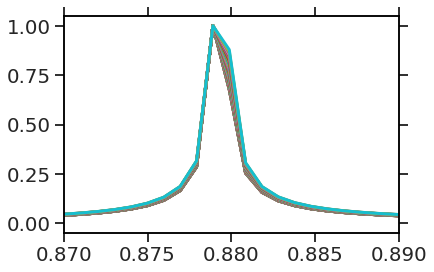

In [36]:
# for x in trackjob.output.particles[0].x.reshape((nturns, 150)).T[:50]:
#     plt.plot(1 - np.fft.rfftfreq(nturns), np.abs(np.fft.rfft(x)) / max(np.abs(np.fft.rfft(x))))
# plt.xlim(0.87, 0.89)

(0.79, 0.81)

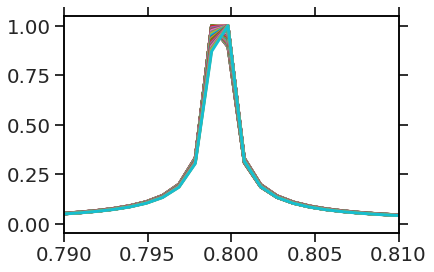

In [35]:
# for y in trackjob.output.particles[0].y.reshape((nturns, 150)).T[50:100]:
#     plt.plot(1 - np.fft.rfftfreq(nturns), np.abs(np.fft.rfft(y)) / max(np.abs(np.fft.rfft(y))))
# plt.xlim(0.79, 0.81)

In [41]:
Jx = compute_J(init_grid, np.zeros(50), beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Jy = compute_J(init_grid, np.zeros(50), beta=twiss['bety'][0], alpha=twiss['alfy'][0])

array([3.59018996, 0.87929937])

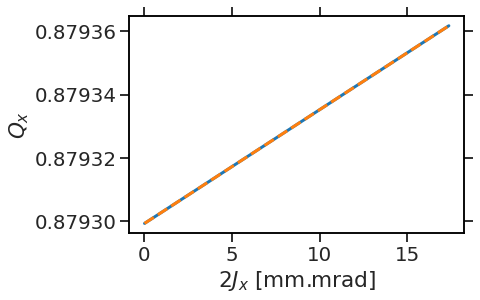

In [54]:
plt.plot(2 * Jx * 1e6, Qx_x)
fit = np.polyfit(2 * Jx, Qx_x, deg=1)
plt.plot(2 * Jx * 1e6, np.poly1d(fit)(2 * Jx), ls='--')
plt.ticklabel_format(style='plain')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('$2J_x$ [mm.mrad]')
plt.ylabel('$Q_x$')
fit

array([3.56986264, 0.79928904])

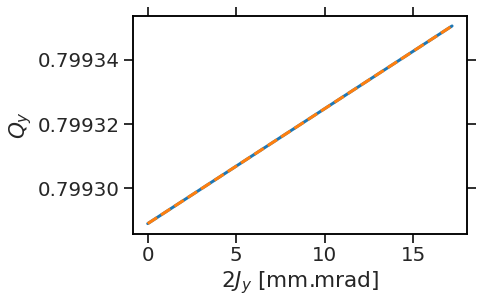

In [55]:
plt.plot(2 * Jy * 1e6, Qy_y)
fit = np.polyfit(2 * Jy, Qy_y, deg=1)
plt.plot(2 * Jy * 1e6, np.poly1d(fit)(2 * Jy), ls='--')
plt.xlabel('$2J_y$ [mm.mrad]')
plt.ylabel('$Q_y$')
fit

array([3.35801245, 0.87929937])

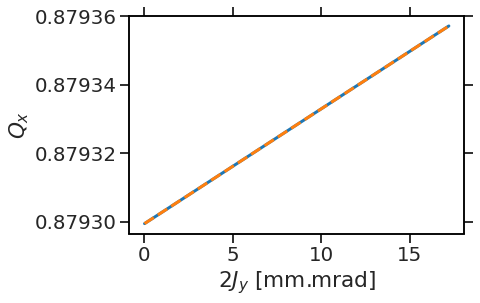

In [56]:
plt.plot(2 * Jy * 1e6, Qx_y)
fit = np.polyfit(2 * Jy, Qx_y, deg=1)
plt.plot(2 * Jy * 1e6, np.poly1d(fit)(2 * Jy), ls='--')
plt.ticklabel_format(style='plain')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('$2J_y$ [mm.mrad]')
plt.ylabel('$Q_x$')
fit